# Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import os
import glob
import nltk
import matplotlib
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Environment Specifics

In [2]:
print('python version: ', os.sys.version)
print('pandas version: ', pd.__version__)
print('numpy version: ', np.__version__)
print('nltk version: ', nltk.__version__)
print('sklearn version: ', sklearn.__version__)
print('wordcloud version: ', wordcloud.__version__)
print('re version: ', re.__version__)
print('matplotlib version: ', matplotlib.__version__)

python version:  3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:38:29) [Clang 13.0.1 ]
pandas version:  1.5.0
numpy version:  1.23.4
nltk version:  3.8.1
sklearn version:  1.2.1
wordcloud version:  1.8.2.2
re version:  2.2.1
matplotlib version:  3.6.2


# Data Loading and Preprocessing

In the cells below we load the data produced by the `build_raw_text_data.ipynb` and `build_mappings.ipynb` notebooks, organizes it into a single dataframe, and then performs standard NLP preprocessing on the data. A detailed description of the process followed can be found in the accompanying report.

In [3]:
# Set seed
np.random.seed(30224)

# Load mappings and raw text data
mappings = pd.read_csv('mappings.csv')
raw_text_data = pd.concat([pd.read_json(f, lines=True) for f in glob.glob('text_data/*.json')])
raw_text_data = raw_text_data.rename(columns={'item_1A':'raw_text'})
print('Number of rows in raw text data:', raw_text_data.shape[0])

# Only keep raw company filings with more than 1000 characters
raw_text_data = raw_text_data[raw_text_data['raw_text'].str.len() > 100].copy()

# Merge mappings and raw text data
cols_mapping = ['cik', 'ticker', 'name_sec', 'sector', 'sub_industry']
cols_raw_text = ['cik', 'raw_text']
data = pd.merge(mappings[cols_mapping], raw_text_data[cols_raw_text], on='cik', how='inner')
print('Number of rows in merged data:', data.shape[0])

Number of rows in raw text data: 493
Number of rows in merged data: 470


In [4]:
def clean_text(text: str, 
               min_len_word: int = 2, 
               additional_stopwords: list = ['inc', 'url', 'sec', 'filing', 'item', 'business']) -> str:
    """Clean text by removing unnecessary characters and altering the format of words.

    Args:
        text (str): Text to be cleaned
        min_len_word (int, optional): Minimum length of word to keep. Defaults to 2.
        additional_stopwords (list, optional): Additional stopwords to remove. Defaults to ['inc', 'url', 'sec', 'filing'].

    Returns:
        str: Cleaned text
    """
    # Initialize the Lemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # List of stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    if additional_stopwords:
        stopwords += additional_stopwords
    # Make text lowercase
    text = text.lower()
    # Remove references to websites
    text = re.sub(r'www\.[^ ]+', '', text)
    text = re.sub(r'http[^ ]+', '', text)
    text = re.sub(r'[^ ]+\.com[^ ]', '', text)
    # Regex to remove all Non-Alpha Numeric, extra spaces, and special characters
    text = re.sub(r'[^a-z\s]', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text, flags=re.IGNORECASE)
    # Remove trailing whitespace
    text = text.strip()
    # Remove stop words or too-short words, lemmatize words, 
    text = text.split()
    text = [lemmatizer.lemmatize(w) for w in text if not w in stopwords]
    text = [w for w in text if len(w) > min_len_word]
    # Join the words back into one string separated by space
    text = " ".join(text)
    return text

In [5]:
# Clean text
data['cleaned_text'] = data['raw_text'].apply(clean_text)
data['tokens'] = data['cleaned_text'].str.split()

# Peek at data
print('Number of rows:', data.shape[0])
data.head()

Number of rows: 470


,cik,ticker,name_sec,sector,sub_industry,raw_text,cleaned_text,tokens
0,320193,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",Item 1. Business Company Background The Co...,company background company design manufacture ...,"[company, background, company, design, manufac..."
1,789019,MSFT,MICROSOFT CORP,Information Technology,Systems Software,PART I Item 1 Note About Forward-Looking Sta...,part note forwardlooking statement report incl...,"[part, note, forwardlooking, statement, report..."
2,1652044,GOOGL,Alphabet Inc.,Communication Services,Interactive Media & Services,ITEM 1.BUSINESS Overview As our founders Larr...,overview founder larry sergey wrote original f...,"[overview, founder, larry, sergey, wrote, orig..."
3,1018724,AMZN,AMAZON COM INC,Consumer Discretionary,Broadline Retail,Item 1.Business This Annual Report on Form 10-...,annual report form document incorporated herei...,"[annual, report, form, document, incorporated,..."
4,1045810,NVDA,NVIDIA CORP,Information Technology,Semiconductors,ITEM 1. BUSINESS Our Company NVIDIA pioneered ...,company nvidia pioneered accelerated computing...,"[company, nvidia, pioneered, accelerated, comp..."


# LSA Clustering

Phase 1: LSA Clustering using standard parameters. The cell below produces Table 1 in the accompanying report.

In [6]:
# Get number of GICS sectors and number of SVD components
n_gics = data['sector'].unique().shape[0]
svd_n_components = 30

# Create pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=False, stop_words=None, sublinear_tf=True)),
    ('reducer', TruncatedSVD(n_components=svd_n_components)),
    ('clusterer', KMeans(n_clusters=n_gics, n_init=10, max_iter=1000)),
])

# Train pipeline
_ = pipeline.fit(data['cleaned_text'])

# Create cluster table
data['clusters'] = pipeline.predict(data['cleaned_text'])
cluster_table = data.groupby(['clusters', 'sector']).size().reset_index().pivot(columns='clusters', index='sector', values=0).fillna(0)

# Print cluster table
display(cluster_table)

clusters,0,1,2,3,4,5,6,7,8,9,10
sector,,,,,,,,,,,
Communication Services,0.0,4.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0
Consumer Discretionary,4.0,2.0,2.0,0.0,0.0,0.0,34.0,0.0,10.0,0.0,0.0
Consumer Staples,0.0,0.0,27.0,0.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0
Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,0.0,0.0
Financials,0.0,24.0,0.0,21.0,0.0,0.0,0.0,1.0,0.0,0.0,20.0
Health Care,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,55.0,0.0
Industrials,0.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,46.0,1.0,0.0
Information Technology,0.0,30.0,0.0,0.0,22.0,0.0,1.0,0.0,8.0,0.0,0.0
Materials,0.0,0.0,7.0,0.0,0.0,0.0,0.0,5.0,15.0,0.0,0.0


# Hyperparameter Tuning

Phase 2: Hyperparameter tuning of LSA Clustering, where we let the number of clusters and the number of SVD dimensions vary. A detailed description of the process followed can be found in the accompanying report.

In [7]:
# Define custom scoring function, using silhouette score, for GridSearchCV
def silhouette_scoring(pipe: Pipeline, X: pd.DataFrame, y: list = None) -> float:
    """Helper function to calculate silhouette score for GridSearchCV on custom pipeline.

    Args:
        pipe (sklearn.pipeline.Pipeline): LSA Pipeline to use for prediction. Must have a KMeans clusterer as the last step.
        X (pd.DataFrame): Array of text to predict on.
        y (list, optional): Target labels, only used for supervised learning. It is present as parameter to make the function compatible with gridsearch. Defaults to None.

    Returns:
        float: Silhouette score.
    """
    # Get labels and features
    labels = pipe.predict(X)
    features = pipe[:-1].transform(X)
    # Return silhouette score
    return silhouette_score(features, labels)

# Define parameter grid
param_grid = {
    'reducer__n_components': list(range(10, 40, 5)),
    'clusterer__n_clusters': list(range(5, 50, 2)),
}

# Use all data for grid search
cv = [(slice(None), slice(None))]

# Run grid search
grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid, 
                    cv=cv, 
                    scoring=silhouette_scoring, 
                    n_jobs=min(os.cpu_count()-1, 5),
                    verbose=1)
_ = grid.fit(data['cleaned_text'])

# Print best parameters
print('Best silhouette score:', grid.best_score_)
print('Best parameters silhouette:', grid.best_params_)

# Add cluster labels to data
data['clusters_optim'] = grid.best_estimator_.predict(data['cleaned_text'])

Fitting 1 folds for each of 138 candidates, totalling 138 fits
Best silhouette score: 0.3153516569801585
Best parameters silhouette: {'clusterer__n_clusters': 11, 'reducer__n_components': 10}


The cell below produces Fig 3 in the accompanying report.

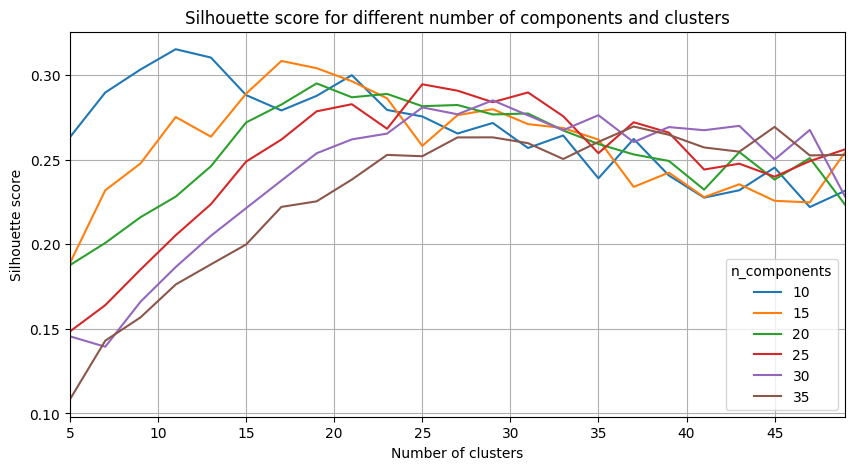

In [8]:
# Get intermediate results from grid search
search_results = pd.DataFrame(grid.cv_results_)
cols_to_keep = ['param_clusterer__n_clusters', 'param_reducer__n_components', 'mean_test_score']
search_results = search_results[cols_to_keep]\
    .rename(columns={'param_clusterer__n_clusters':'n_clusters', 'param_reducer__n_components':'n_components', 'mean_test_score':'silhouette_score'})
search_results = search_results.astype({'n_clusters':int, 'n_components':int, 'silhouette_score':float})
# Pivot results
search_results = search_results.pivot(index='n_clusters', columns='n_components', values='silhouette_score')
# Plot results
fig, ax = plt.subplots(figsize=(10, 5))
search_results.plot(ax=ax)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette score for different number of components and clusters')
ax.grid(True)
ax.set_xlim([search_results.index.min(), search_results.index.max()])
plt.show()

# Word Cloud

An example of a word cloud for a cluster. The cell below produces Fig 2 in the accompanying report.

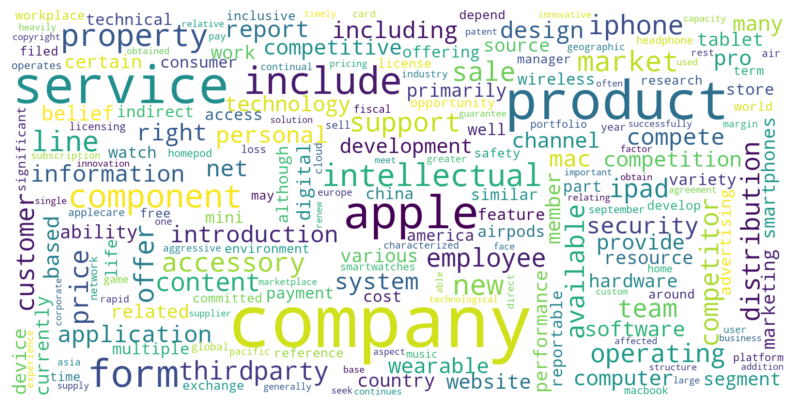

In [9]:
# Get apple index
idx = data[data['ticker'] == 'AAPL'].index[0]

# Generate word cloud
word_cloud = WordCloud(background_color='white', max_font_size=150, random_state=30224, collocations=False, width=1600, height=800)
word_cloud = word_cloud.generate(data.loc[idx, 'cleaned_text'])

# Plot word cloud
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(word_cloud, interpolation='bilinear')
ax.axis('off')
plt.show()